In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
# import plotly_express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats
from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn import tree
# import graphviz

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.neighbors import KNeighborsClassifier 

import seaborn as sns

%matplotlib inline

Считываем все файлы

In [40]:
df_sales_train = pd.read_csv('/Users/roman/Desktop/1C Kaggle/sales_train.csv')
df_item_categories = pd.read_csv('/Users/roman/Desktop/1C Kaggle/item_categories.csv')
df_items = pd.read_csv('/Users/roman/Desktop/1C Kaggle/items.csv')
df_shops = pd.read_csv('/Users/roman/Desktop/1C Kaggle/shops.csv')
df_test = pd.read_csv('/Users/roman/Desktop/1C Kaggle/test.csv')

Так как item_cnt_day содержит отрицательные значения (возврат товара), убираем их, чтобы они не путали модель. Факт продажи уже был учтен в данных один раз.

In [41]:
df_sales_train = df_sales_train[df_sales_train['item_cnt_day'] > 0]

Соединяем отдельные файлы в один dataframe

In [42]:
total = pd.merge(df_sales_train, df_items, how='left', left_on='item_id', right_on='item_id')
total = pd.merge(total, df_item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
item = total['item_category_id'].unique()
shop = total['shop_id'].unique()

Выделяем категории товаров/услуг. Так как могут быть разные предпосылки продаж для каждой категории. Для анализа возьмем категорию "Кино"

In [43]:
lst = []
for i in range(len(item)):
    first_predict = total[(total['item_category_id'] == item[i])][['date_block_num', 'shop_id', 'item_id', 'item_cnt_day', 'item_category_id', 'item_category_name', 'item_name']]
    lst.append(first_predict)
df = pd.concat(lst)

films = lst[0]

Встречаются товары, которые были проданы больше одного раза при тех же признаках, что и раньше(в одном магазине, в одном месяце), поэтому заменим такие продажи одним общим значением - максимальное количество продаж

In [44]:
films = films.groupby(by=['shop_id', 'date_block_num','item_id']).agg({'item_cnt_day': np.max}).reset_index()
films['item_cnt_day'] = films['item_cnt_day'].apply(int)
films['date_block_num'] = films['date_block_num'].apply(lambda x: x % 12 + 1)

Разметим классы одна продажа и больше одной продажи. При разбивке на большее количество классов модель показывала плохой прогноз, поэтому принято решение разбить на два класса из-за несбалансированности выборки

In [45]:
def get_class_films(count_sales):
    if count_sales < 0:
        return 0
    if count_sales == 1:
        return count_sales 
    if count_sales > 1:
        return 2
    return count_sales

Добавляем новый столбец с классами и удаляем предыдущий

In [46]:
films['class_item_cnt_day'] = films['item_cnt_day'].apply(get_class_films)
films = films.drop('item_cnt_day', axis=1)

In [67]:
films['class_item_cnt_day'].value_counts()
print(films['class_item_cnt_day'].value_counts())

1    128792
2      5684
Name: class_item_cnt_day, dtype: int64


Разбиваем нашу выборку на test/train

In [48]:
X_train_first, X_test, y_train_first, y_test = train_test_split(films.drop('class_item_cnt_day', axis=1), films['class_item_cnt_day'], test_size=0.2)

In [95]:
graph_first = pd.concat([X_train_first, y_train_first], axis=1)
print(graph_first['class_item_cnt_day'].value_counts())

1    103032
2      4548
Name: class_item_cnt_day, dtype: int64


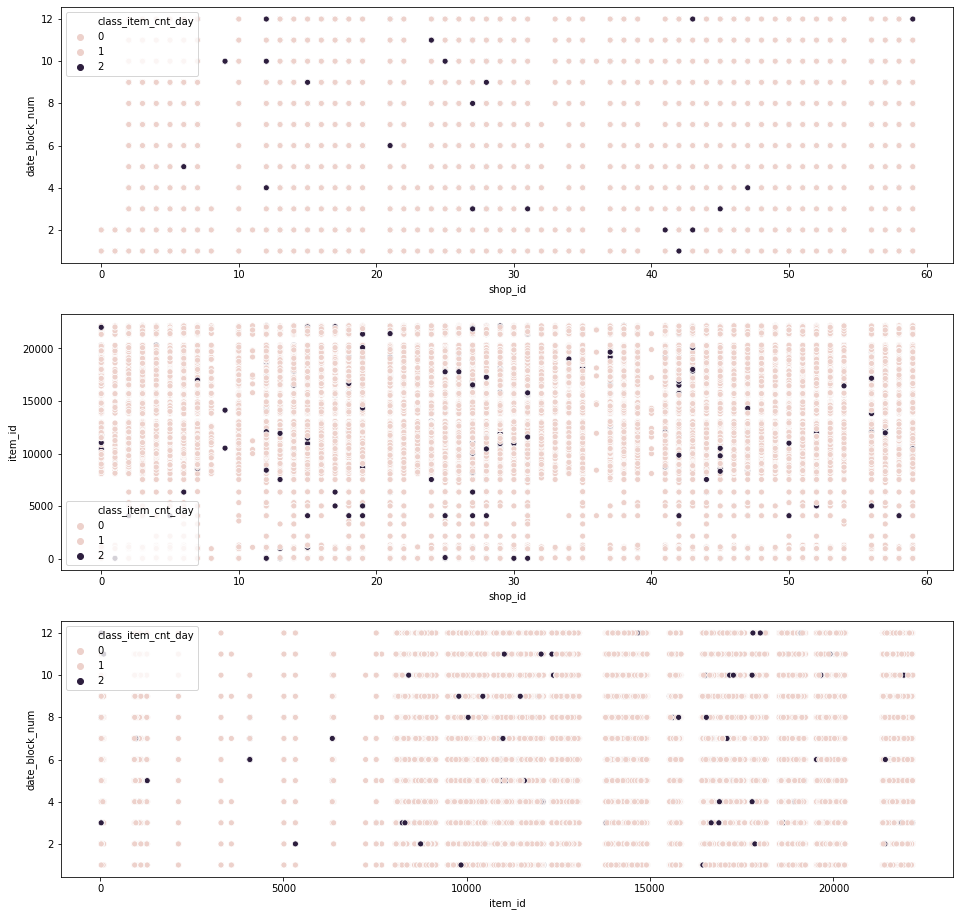

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,16))
sns.scatterplot(x='shop_id', y='date_block_num', data=graph, hue='class_item_cnt_day', ax=ax1)
sns.scatterplot(x='shop_id', y='item_id', data=graph, hue='class_item_cnt_day', ax=ax2)
sns.scatterplot(x='item_id', y='date_block_num', data=graph, hue='class_item_cnt_day', ax=ax3)

In [52]:
models = [RandomForestClassifier(criterion='entropy'), RandomForestClassifier(criterion='gini'), 
          KNeighborsClassifier(n_neighbors = 3), KNeighborsClassifier(n_neighbors = 6)]

In [53]:
models_name = ['RandomForestClassifier(entropy)', 'RandomForestClassifier(gini)', 
          'KNeighborsClassifier(n_neighbors = 3)', 'KNeighborsClassifier(n_neighbors = 6)']

In [54]:
def fit_predict(models, X_train,y_train):
    model = models
    model = model.fit(X_train,y_train)
    y_predict = model.predict(X_test)
    p = metrics.precision_score(y_predict, y_test, average=None)
    r = metrics.recall_score(y_predict, y_test, average=None)
    a = metrics.accuracy_score(y_predict, y_test)
    s = pd.Series(y_train).value_counts()
    df = {'precision': pd.Series(p, index=[1, 2]), 'recall': pd.Series(r, index=[1, 2]),
          'accuracy': pd.Series(a, index=[1, 2]), 'sample': pd.Series(s, index=[1, 2])}
    df = pd.DataFrame(df)
    print(df)

In [55]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train_first, y_train_first)

RandomForestClassifier(entropy)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


   precision    recall  accuracy  sample
1   0.978455  0.959569   0.93988  103032
2   0.065141  0.117647   0.93988    4548
RandomForestClassifier(gini)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


   precision    recall  accuracy  sample
1   0.979425  0.959316  0.940512  103032
2   0.058099  0.110738  0.940512    4548
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.982415  0.962243  0.946237  103032
2   0.125880  0.239933  0.946237    4548
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.996972  0.959178  0.956462  103032
2   0.037852  0.355372  0.956462    4548


Простое дублирование данных

In [76]:
ros = RandomOverSampler(random_state=1)
X_train, y_train = ros.fit_resample(X_train_first, y_train_first)

In [85]:
graph_second = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
graph_second.columns = ['shop_id', 'date_block_num','item_id', 'class_item_cnt_day']

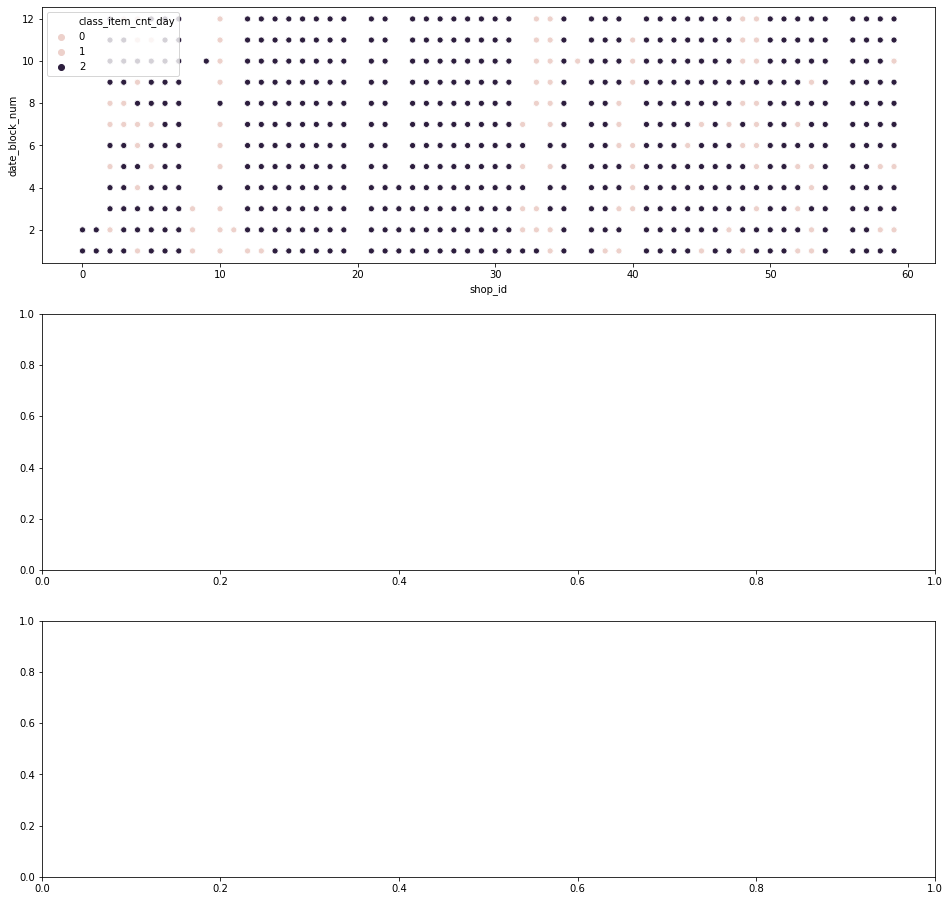

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,16))
sns.scatterplot(x='shop_id', y='date_block_num', data=graph_second, hue='class_item_cnt_day', ax=ax1)
# sns.scatterplot(x='shop_id', y='item_id', data=graph_second, hue='class_item_cnt_day', ax=ax2)
# sns.scatterplot(x='item_id', y='date_block_num', data=graph_second, hue='class_item_cnt_day', ax=ax3)

In [57]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.956599  0.960477  0.920732  103032
2   0.107394  0.098387  0.920732  103032
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.959084  0.960650  0.923186  103032
2   0.109155  0.105263  0.923186  103032
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.911840  0.972307   0.89069  103032
2   0.411092  0.170562   0.89069  103032
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.886258  0.974309  0.868679  103032
2   0.470070  0.154157  0.868679  103032


In [58]:
Oversampling = [SMOTE(random_state=1), BorderlineSMOTE(random_state = 1, kind = 'borderline-1'), 
                SVMSMOTE(random_state = 1), SMOTENC([0, 1, 2],random_state = 1), ADASYN(random_state = 1)]

Не работате с категориальными признаками. Выбирает соседей рандомно. Самый простой метод.

In [59]:
smote = SMOTE(random_state = 2)
X_train, y_train = smote.fit_resample(X_train_first, y_train_first)

In [60]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.838703  0.973812  0.823914  103032
2   0.488556  0.117834  0.823914  103032
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.834938  0.973653  0.820271  103032
2   0.487676  0.115273  0.820271  103032
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.851902  0.976679  0.838675  103032
2   0.538732  0.138243  0.838675  103032
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.854775  0.976842  0.841501  103032
2   0.540493  0.140987  0.841501  103032


Учитывает случаи, когда соседи могут быть разных классов. Использует k/2 < m < k (мажоритарный класс)

In [61]:
blsmote = BorderlineSMOTE(random_state = 1, kind = 'borderline-1')
X_train, y_train = blsmote.fit_resample(X_train_first, y_train_first)

In [62]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.887849  0.971126  0.867304  103032
2   0.401408  0.136323  0.867304  103032
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.881871  0.971352   0.86195  103032
2   0.410211  0.132801   0.86195  103032
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.887811  0.974435  0.870241  103032
2   0.471831  0.156451  0.870241  103032
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.886102  0.974512  0.868717  103032
2   0.474472  0.155197  0.868717  103032


In [63]:
svmsmote = SVMSMOTE(random_state = 1)
X_train, y_train = svmsmote.fit_resample(X_train_first, y_train_first)

In [64]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.899806  0.970604  0.877937  103032
2   0.382042  0.143947  0.877937  103032
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.906871  0.970827  0.884704  103032
2   0.382042  0.153194  0.884704  103032
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.897904  0.973854  0.879127  103032
2   0.453345  0.163752  0.879127  103032
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.900427  0.973067  0.880763  103032
2   0.434859  0.161491  0.880763  103032


Единственный метод, который умеет работать с категориальными признаками

In [71]:
X_train_first['add'] = 1
smotenc = SMOTENC([0, 1, 2],random_state = 1)
X_train, y_train = smotenc.fit_resample(X_train_first, y_train_first)

In [72]:
X_train = X_train[:, :-1]

In [73]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.978416  0.959166  0.939433  103032
2   0.055458  0.101777  0.939433  103032
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.981716  0.959116  0.942408  103032
2   0.051056  0.109641  0.942408  103032
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.982570  0.962139  0.946275  103032
2   0.123239  0.237691  0.946275  103032
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.996739  0.959062  0.956127  103032
2   0.035211  0.322581  0.956127  103032


метод ADASYN не устойчив к выбросам (уделяет большое внимание областям с низкой плотностью)

In [74]:
X_train_first.drop(['add'], axis=1, inplace=True)
ad = ADASYN(random_state = 1)
X_train, y_train = ad.fit_resample(X_train_first, y_train_first)

In [75]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.820691  0.973119  0.806551  103032
2   0.485915  0.106749  0.806551  102313
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.826359  0.972987  0.811719  103032
2   0.479754  0.108609  0.811719  102313
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.844410  0.976477  0.831499  103032
2   0.538732  0.132468  0.831499  102313
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.844604  0.977052  0.832168  103032
2   0.550176  0.135048  0.832168  102313


UNDERSAMPLING

In [29]:
# cc = ClusterCentroids(random_state=0)
# X_train, y_train = cc.fit_resample(X_train, y_train)

In [54]:
rus = RandomUnderSampler(random_state=1)
X_train, y_train = rus.fit_resample(X_train_first, y_train_first)

In [55]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.674557  0.975862  0.672182    4559
2   0.617778  0.076525  0.672182    4559
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.673043  0.976633  0.671289    4559
2   0.631111  0.077715  0.671289    4559
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.612239  0.983359  0.618531    4559
2   0.762667  0.079071  0.618531    4559
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.685965  0.979336  0.685232    4559
2   0.668444  0.085020  0.685232    4559


In [ ]:
nm1 = NearMiss(version=2)
X_train, y_train = nm1.fit_resample(X_train_first, y_train_first)

In [36]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.402953  0.966713  0.413928    4590
2   0.672761  0.045598  0.413928    4590
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.398380  0.965527  0.409206    4590
2   0.664534  0.044738  0.409206    4590
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.261724  0.950190  0.278592    4590
2   0.676417  0.037395  0.278592    4590
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.412565  0.946811  0.414225    4590
2   0.453382  0.031687  0.414225    4590


In [26]:
enn = EditedNearestNeighbours()
X_train, y_train = enn.fit_resample(X_train_first, y_train_first)

In [27]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.981048  0.962545  0.945196   92830
2   0.099634  0.182274  0.945196    4590
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.980350  0.963032  0.945048   92830
2   0.112431  0.195238  0.945048    4590
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.952058  0.971409  0.927127   92830
2   0.339122  0.230721  0.927127    4590
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.979847  0.965625  0.947204   92830
2   0.177331  0.271709  0.947204    4590


In [28]:
renn = RepeatedEditedNearestNeighbours()
X_train, y_train = renn.fit_resample(X_train_first, y_train_first)

In [29]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.976281  0.963326   0.94159   85683
2   0.123400  0.180723   0.94159    4590
RandomForestClassifier(gini)
   precision   recall  accuracy  sample
1   0.975777  0.96316  0.940958   85683
2   0.119744  0.17328  0.940958    4590
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.911208  0.975641  0.892995   85683
2   0.463437  0.181201  0.892995    4590
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.955624  0.969260  0.928354   85683
2   0.285192  0.214139  0.928354    4590


In [31]:
allknn = AllKNN()
X_train, y_train = allknn.fit_resample(X_train_first, y_train_first)

In [32]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

RandomForestClassifier(entropy)
   precision    recall  accuracy  sample
1   0.979420  0.963329   0.94449   89945
2   0.120658  0.199095   0.94449    4590
RandomForestClassifier(gini)
   precision    recall  accuracy  sample
1   0.978800  0.963380  0.943969   89945
2   0.122486  0.196769  0.943969    4590
KNeighborsClassifier(n_neighbors = 3)
   precision    recall  accuracy  sample
1   0.936439  0.973136  0.914225   89945
2   0.390311  0.206580  0.914225    4590
KNeighborsClassifier(n_neighbors = 6)
   precision    recall  accuracy  sample
1   0.971165  0.967005  0.940549   89945
2   0.218464  0.243133  0.940549    4590


In [34]:
cnn = CondensedNearestNeighbour(random_state=0)
X_train, y_train = cnn.fit_resample(X_train_first, y_train_first)

KeyboardInterrupt: 

In [ ]:
for x in range(len(models)):
    print(models_name[x])
    fit_predict(models[x], X_train, y_train)

In [205]:
films_2 = films.copy()
films_2 = films_2[films_2['class_item_cnt_day'] == 1]
films_2['class_item_cnt_day'].count()

128792

In [206]:
films_2 = films_2.sample(frac=0.1)
films_2['class_item_cnt_day'].count()

12879

In [207]:
films_3 = films.drop(np.where(films['class_item_cnt_day'] == 1)[0])
pd.Series(films_3['class_item_cnt_day']).value_counts()

2    5684
Name: class_item_cnt_day, dtype: int64

In [208]:
films_3 = pd.concat([films_2, films_3])
pd.Series(films_3['class_item_cnt_day']).value_counts()

1    12879
2     5684
Name: class_item_cnt_day, dtype: int64

In [209]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(films_3.drop('class_item_cnt_day', axis=1), films_3['class_item_cnt_day'], test_size=0.2)

In [210]:
X_train_2, y_train_2 = sm.fit_sample(X_train_2, y_train_2.ravel())
pd.Series(y_train_2).value_counts()

2    10297
1    10297
dtype: int64

In [211]:
model_2 = RandomForestClassifier(criterion='gini')
model_2 = model_2.fit(X_train_2,y_train_2)
y_predict_2 = model_2.predict(X_test_2)
print(metrics.classification_report(y_predict_2, y_test_2))

              precision    recall  f1-score   support

           1       0.77      0.80      0.79      2499
           2       0.56      0.52      0.54      1214

    accuracy                           0.71      3713
   macro avg       0.67      0.66      0.66      3713
weighted avg       0.70      0.71      0.71      3713



/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [212]:
test = pd.merge(df_items, df_item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
test_2 = pd.merge(test, df_test, how='left', left_on='item_id', right_on='item_id')
test_2

,item_name,item_id,item_category_id,item_category_name,ID,shop_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,NaN,NaN
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра),NaN,NaN
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,NaN,NaN
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,NaN,NaN
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,NaN,NaN
...,...,...,...,...,...,...
231265,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Книги - Методические материалы 1С,199377.0,44.0
231266,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Книги - Методические материалы 1С,204477.0,39.0
231267,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Книги - Методические материалы 1С,209577.0,45.0
231268,Яйцо для Little Inu,22168,62,"Подарки - Гаджеты, роботы, спорт",NaN,NaN


In [213]:
test_2[test_2['item_category_id']==40]['item_name'].to_excel('test_films.xlsx')

Метод KNN

In [214]:
KNN_2 = KNeighborsClassifier(n_neighbors = 6)
KNN_2 = KNN_2.fit(X_train_2,y_train_2)
y_predict_4 = KNN_2.predict(X_test_2)
print(metrics.classification_report(y_predict_4, y_test_2))

              precision    recall  f1-score   support

           1       0.74      0.84      0.78      2254
           2       0.69      0.53      0.60      1459

    accuracy                           0.72      3713
   macro avg       0.71      0.69      0.69      3713
weighted avg       0.72      0.72      0.71      3713



In [215]:
XGb = XGBClassifier()
XGb = XGb.fit(X_train_2,y_train_2)
y_predict_5 = XGb.predict(X_test_2.to_numpy())
print(metrics.classification_report(y_predict_5, y_test_2))

              precision    recall  f1-score   support

           1       0.65      0.79      0.71      2113
           2       0.61      0.43      0.51      1600

    accuracy                           0.64      3713
   macro avg       0.63      0.61      0.61      3713
weighted avg       0.63      0.64      0.63      3713

